# Seq2seq (Encoder+Decoder) LSTM

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
ENCODER_TIMESTEPS = 12  # Input 12 months to predict next month
DECODER_TIMESTEPS = 6  # Slide 6 months when decoder predicts

## 1. Read in dataset

In [9]:
data = pd.read_csv('/kaggle/input/airline-passengers/Airline passengers.csv')
data.index = pd.to_datetime(data.Month)  # Set datetime index
data.drop(['Month'], axis=1, inplace=True)

<Axes: title={'center': 'Monthly airline passengers'}, xlabel='Month'>

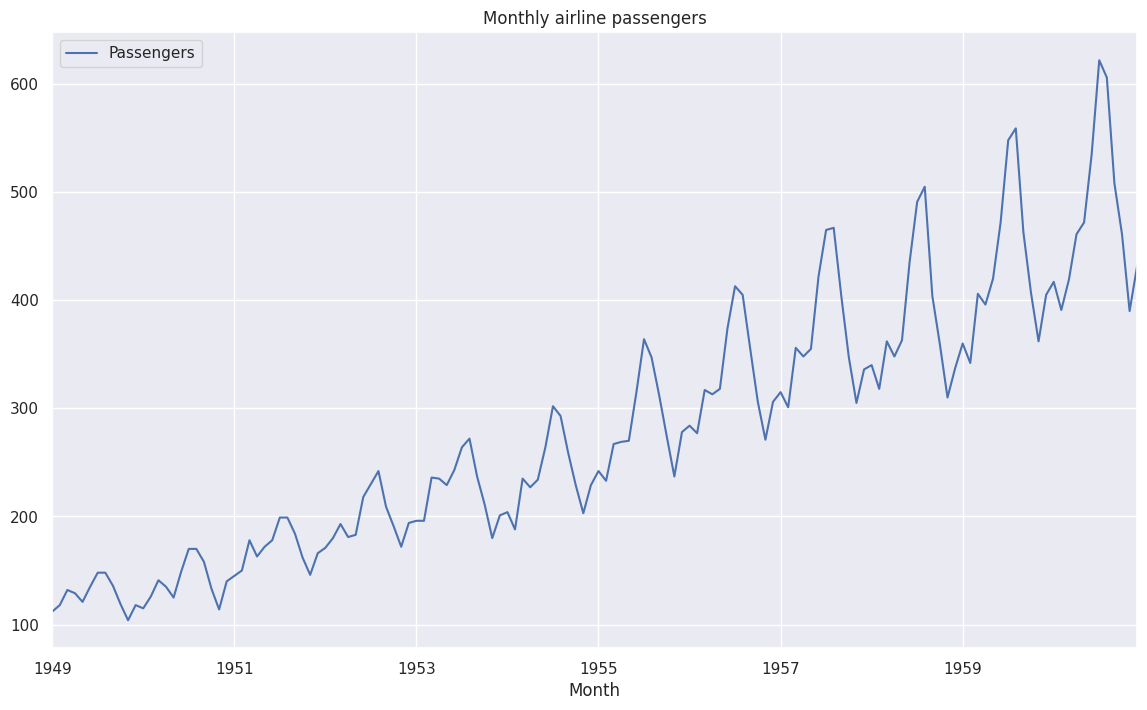

In [10]:
data.plot(figsize=(14, 8), title='Monthly airline passengers')

## 2.1 Normalize dataset

<Axes: title={'center': 'Monthly normalized airline passengers'}, xlabel='Month'>

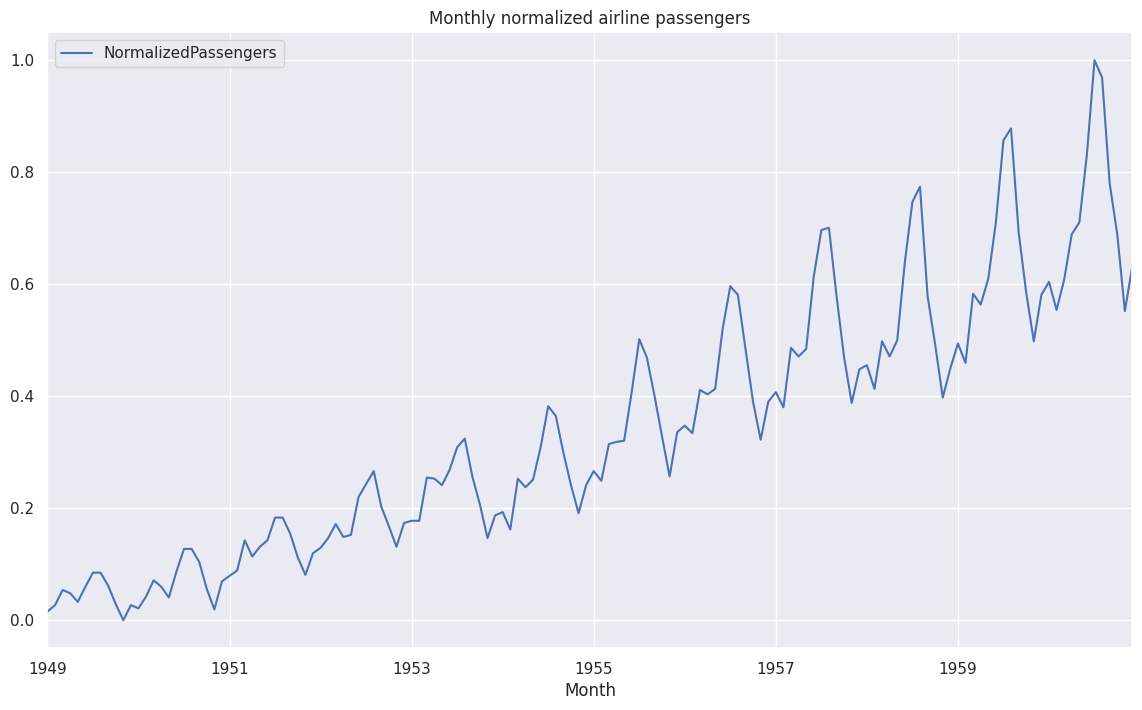

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedPassengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1)).flatten()
data[['NormalizedPassengers']].plot(figsize=(14, 8), title='Monthly normalized airline passengers')

## 2.2 Preprocess dataset

In [12]:
def create_dataset(data, enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    X_encoder, X_decoder, y, y_date, start_values = [], [], [], [], []

    for i in range(len(data) - enc_timesteps - dec_timesteps):
        Xt_encoder = data.iloc[i:i+enc_timesteps].values
        Xt_decoder = data.iloc[i+enc_timesteps-dec_timesteps:i+enc_timesteps].values
        yt = data.iloc[i+enc_timesteps:i+enc_timesteps+dec_timesteps].values
        yt_date = data.index[i+enc_timesteps].to_pydatetime()  # Get start date of decoder output

        # Subtract a start value from each values in the timestep.
        start_value = Xt_encoder[0]
        Xt_encoder = Xt_encoder - start_value
        Xt_decoder = Xt_decoder - start_value
        yt = yt - start_value

        X_encoder.append(Xt_encoder)
        X_decoder.append(Xt_decoder)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)

    return np.array(X_encoder), np.array(X_decoder), np.array(y), y_date, start_values

In [13]:
def split_train_valid_test(X_encoder, X_decoder, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])

    X_encoder_train = X_encoder[:train_end_idx+1, :]
    X_encoder_valid = X_encoder[train_end_idx+1:valid_end_idx+1, :]
    X_encoder_test = X_encoder[valid_end_idx+1:, :]

    X_decoder_train = X_decoder[:train_end_idx+1, :]
    X_decoder_valid = X_decoder[train_end_idx+1:valid_end_idx+1, :]
    X_decoder_test = X_decoder[valid_end_idx+1:, :]

    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]

    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]

    return X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
                y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [14]:
# Create input and output pairs for training lstm.
X_encoder, X_decoder, y, y_date, start_values = create_dataset(data[['NormalizedPassengers']])

# Split X and y into train, valid, and test periods.
X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, X_encoder_test, X_decoder_test, \
    y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X_encoder, X_decoder, y, y_date)

In [15]:
print(X_encoder_train.shape, X_encoder_valid.shape, X_encoder_test.shape)
print(X_decoder_train.shape, X_decoder_valid.shape, X_decoder_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(84, 12, 1) (24, 12, 1) (18, 12, 1)
(84, 6, 1) (24, 6, 1) (18, 6, 1)
(84, 6, 1) (24, 6, 1) (18, 6, 1)


## 3. Create seq2seq (Encoder+Decoder) LSTM model

In [39]:
def create_model(enc_timesteps=ENCODER_TIMESTEPS, dec_timesteps=DECODER_TIMESTEPS):
    # Create encoder
    encoder_inputs = Input(shape=(enc_timesteps, 1), name='encoder_input')
    encoder, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]

    encoder_outputs, state_h2, state_c2 = LSTM(32, return_state=True, name='encoder_lstm_2')(encoder)
    encoder_states2 = [state_h2, state_c2]

    # Create decoder
    decoder_inputs = Input(shape=(dec_timesteps, 1), name='decoder_input')
    decoder, _, _ = LSTM(128, return_sequences=True, return_state=True, name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_states1)
    decoder, _, _ = LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)


    # Create output layer
    decoder_outputs = Dense(1)(decoder)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.01), metrics=['mean_absolute_error'])
    return model

In [42]:
model = create_model()
callbacks = [
    ModelCheckpoint('model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Start training model.
fit = model.fit(
    [X_encoder_train, X_decoder_train], y_train,
    batch_size=32,
    epochs=100,
    verbose=2,
    validation_data=([X_encoder_valid, X_decoder_valid], y_valid))

Epoch 1/100
3/3 - 3s - 972ms/step - loss: 0.0168 - mean_absolute_error: 0.1111 - val_loss: 0.0186 - val_mean_absolute_error: 0.1062
Epoch 2/100
3/3 - 0s - 21ms/step - loss: 0.0061 - mean_absolute_error: 0.0609 - val_loss: 0.0172 - val_mean_absolute_error: 0.1014
Epoch 3/100
3/3 - 0s - 20ms/step - loss: 0.0053 - mean_absolute_error: 0.0556 - val_loss: 0.0157 - val_mean_absolute_error: 0.0966
Epoch 4/100
3/3 - 0s - 20ms/step - loss: 0.0048 - mean_absolute_error: 0.0524 - val_loss: 0.0134 - val_mean_absolute_error: 0.0943
Epoch 5/100
3/3 - 0s - 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0130 - val_mean_absolute_error: 0.0964
Epoch 6/100
3/3 - 0s - 20ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0110 - val_mean_absolute_error: 0.0866
Epoch 7/100
3/3 - 0s - 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0133 - val_mean_absolute_error: 0.0898
Epoch 8/100
3/3 - 0s - 20ms/step - loss: 0.0043 - mean_absolute_error: 0.0495 - va

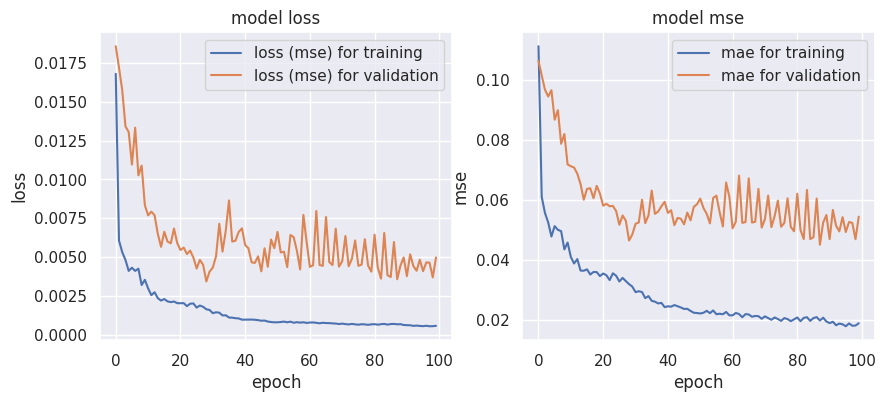

In [44]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()


In [45]:
def evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
                   X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
                  pred_timesteps=0):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'
    Params:
        pred_timesteps (int): (t + T + pred_timesteps)th month if predicted from t ~ t + T months
    """

    # Predict next month passengers
    pred_train = model.predict([X_encoder_train, X_decoder_train])[:, pred_timesteps]
    pred_valid = model.predict([X_encoder_valid, X_decoder_valid])[:, pred_timesteps]
    pred_test = model.predict([X_encoder_test, X_decoder_test])[:, pred_timesteps]

    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_encoder_train)]
    pred_valid  = pred_valid + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    pred_test  = pred_test + start_values[len(X_encoder_train)+len(X_encoder_valid):]

    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()

    # Plot prediction result
    pred_df = pd.DataFrame({
        'Passengers': data['Passengers'].values,
        'PredictionTrain': np.nan, 'PredictionValid': np.nan, 'PredictionTest': np.nan
    })

    train_start_idx = ENCODER_TIMESTEPS + pred_timesteps
    valid_start_idx = train_start_idx + len(pred_train)
    test_start_idx = valid_start_idx + len(pred_valid)

    pred_df.loc[train_start_idx:valid_start_idx - 1, 'PredictionTrain'] = pred_train
    pred_df.loc[valid_start_idx:test_start_idx-1, 'PredictionValid'] = pred_valid
    pred_df.loc[test_start_idx:test_start_idx+ len(pred_test)-1, 'PredictionTest'] = pred_test

    pred_df.idx =  data.index
    pred_df[['Passengers', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted monthly airline passengers')

    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train[:, pred_timesteps] + start_values[:len(X_encoder_train)]
    y_valid  = y_valid[:, pred_timesteps] + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
    y_test  = y_test[:, pred_timesteps] + start_values[len(X_encoder_train)+len(X_encoder_valid):]

    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()

    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
train rmse: 10.366758, mae: 7.866770
valid rmse: 28.969645, mae: 22.098484
test rmse: 28.668445, mae: 24.246043


/tmp/ipykernel_30/3447659533.py:38: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred_df.idx =  data.index


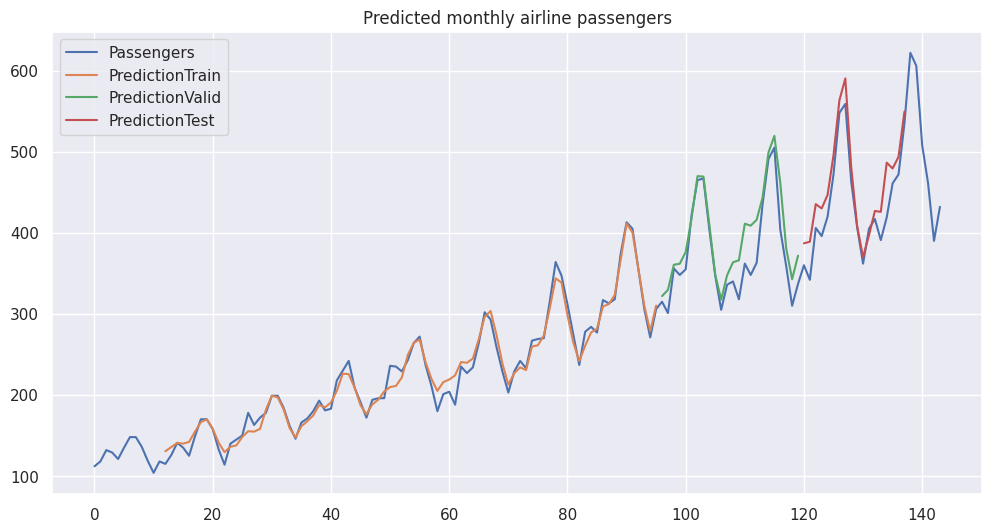

In [46]:
# Predict next month.
evaluate_model(data, scaler, X_encoder_train, X_decoder_train, X_encoder_valid, X_decoder_valid, \
               X_encoder_test, X_decoder_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model, \
              pred_timesteps=0)